In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
# --- define start and end dates of vacation ---
start_date = '2018-06-01'
end_date = '2018-06-15'

# --- convert string date to date format for use with datetime library ---
start_dt = (dt.datetime.strptime(start_date, "%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date, "%Y-%m-%d")).date()

# --- calculate the dates 1 year ago from the start_date and end_date (using dt.timedelta) ---
startdate_oneyearago = start_dt - dt.timedelta(days=365)
enddate_oneyearago = end_dt - dt.timedelta(days=365)

# --- call the calc_temps function with the previous year dates calculated above ---
temps = calc_temps(startdate_oneyearago, enddate_oneyearago)
tmin = temps[0][0]
tavg = round(temps[0][1], 2)
tmax = temps[0][2]

# --- display temperature info ---
print(f"Vacation start date: {start_date} | Vacation end date: {end_date}")
print("----------------------------------------------------------------")
print(f"Temperatures from {startdate_oneyearago} to {enddate_oneyearago}:")
print(f"Minimum temp: {tmin} | Average temp: {tavg} | Max temp: {tmax}")

Vacation start date: 2018-06-01 | Vacation end date: 2018-06-15
----------------------------------------------------------------
Temperatures from 2017-06-01 to 2017-06-15:
Minimum temp: 72.0 | Average temp: 77.42 | Max temp: 83.0


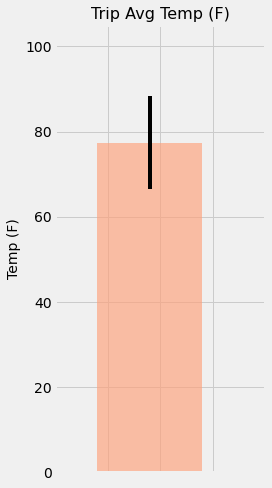

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# --- calculate yerror value ((tmax-tmin) ---
yerror = tmax-tmin

# --- plot data as bar chart ---
plt.figure(figsize = (4,7))
plt.bar(1.5, height=tavg, yerr=yerror, width = 2, color='lightsalmon', alpha = 0.65,  align='center')
xaxis_values = np.arange(-0.3,3.8, step=1)
plt.title("Trip Avg Temp (F)", fontsize = 16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0,105)
plt.xticks(xaxis_values, "")

plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

### Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# --- get all precipitation data from dataset for one year ago dates using SQLAlchemy and save in dataframe ---
prcp_station_df = pd.DataFrame(session.query(Measurement.date, Measurement.station, Measurement.prcp).\
                               filter((Measurement.date >= startdate_oneyearago) & \
                               (Measurement.date <= enddate_oneyearago)).all())

# --- check and drop null values from prcp_station_df---
print("Checking for null values...")
print(f"There are {prcp_station_df['prcp'].isnull().sum()} null values in the precipitation data - dropping!")

prcp_station_df.dropna(axis=0, how="any", inplace=True)

# --- group by station and get total precipitation amount for each station ---
total_prcp = pd.DataFrame(prcp_station_df.groupby('station').sum())

# --- get station data from station table and save in dataframe ---
station_df = pd.DataFrame(session.query(Station.station, Station.name, Station.latitude, Station.longitude,\
                                        Station.elevation).all())


# --- merge the two dataframes together, sort by total precipitation amount ---
rainfall_per_station_df = pd.merge(total_prcp, station_df, on="station").rename(columns={"prcp":"total precipitation (in)"})
rainfall_per_station_df.sort_values('total precipitation (in)', ascending=False, inplace=True)
rainfall_per_station_df.reset_index(inplace=True, drop=True)

# --- display the dataframe ---
rainfall_per_station_df

Checking for null values...
There are 11 null values in the precipitation data - dropping!


,station,total precipitation (in),name,latitude,longitude,elevation
0,USC00516128,5.51,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.98,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00514830,2.02,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00513117,1.96,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519523,0.76,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.16,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [25]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = (dt.datetime.strptime('2018-06-01', "%Y-%m-%d")).date()
end_date = (dt.datetime.strptime('2018-06-15', "%Y-%m-%d")).date()

# Use the start and end date to create a range of dates

# --- create an empty list to store range of dates ---
trip_dates = []

# --- new variable to act as start date (so that actual start date is unchanged) ---
current_date = start_date

# --- while loop to append dates to list in the format %m-%d ---
while current_date <= end_date:
    month = current_date.strftime('%m')
    day = current_date.strftime('%d')
    trip_dates.append(f"{month}-{day}")
    current_date += dt.timedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date

# --- create an empty list to store normals ---
normals = []

# --- for loop to calculate normals for each date in trip_dates list ---
for i in range(len(trip_dates)):
    day_normal = daily_normals(trip_dates[i])
    normals.append(day_normal[0])


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dailynormals_df = pd.DataFrame(normals, columns =['T-Min (F)', 'T-Avg (F)', 'T-Max(F)']) 
dailynormals_df["Date"] = trip_dates
dailynormals_df.set_index("Date")

,T-Min (F),T-Avg (F),T-Max(F)
Date,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0


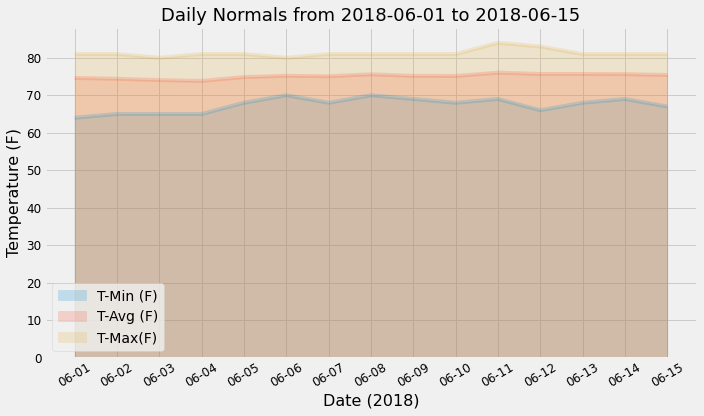

In [29]:
# Plot the daily normals as an area plot with `stacked=False`

dailynormals_df.plot.area(figsize=(10,6), stacked=False, alpha = 0.2, rot=30, fontsize=12)

plt.xticks(np.arange(len(trip_dates)), labels=trip_dates)

plt.title(f"Daily Normals from {start_date} to {end_date}", fontsize=18)
plt.xlabel("Date (2018)", fontsize=16)
plt.ylabel("Temperature (F)", fontsize=16)

plt.tight_layout()
plt.savefig("Images/dailynormals.png")
plt.show()

## Close Session

In [30]:
session.close()